# sLASER basis spectra creation
This notebook creates a basis set for the 125 ms diffusion-sLASER sequence used to created dataset 2, and described in [this documentation](https://github.com/dwmrshub/pregame-workshop-2021/blob/main/InVivo-Data/Data2/DW-sLASER_readme). 

You will need:
1. A copy of [FSL-MRS](https://open.win.ox.ac.uk/pages/fsl/fsl_mrs/install.html)
2. A copy of the `pregame` data `git clone https://github.com/dwmrshub/pregame-workshop-2021.git`
3. A copy of the refocusing pulse frequency modulation chronogram, available from the organisers.
4. A copy of the Bloch simulator used `git clone https://github.com/wexeee/bloch-simulator-python.git`

In [16]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the chronogram
Load one of the chronograms containing the pulse amplitude modulations and gradients.
Each point is 6.4 us.

Additionally load the frequency modulation `AM_sLASER.csv` and add it to the dataframe.

In [17]:
chrono_g10_dir1 = pd.read_csv('../pregame-workshop-2021/InVivo-Data/Data2/chronogram/chronogram_G10_dir1.csv')
AM_sLASER = pd.read_csv('AM_sLASER.csv')
# Add in frequency modulation
chrono_g10_dir1 = pd.concat((chrono_g10_dir1,AM_sLASER.rename(columns={'0':'RF_freq'})),axis=1)
# Timings - each point is 6.4 us
chrono_g10_dir1.index = chrono_g10_dir1.index*6.4/1000 # Express in ms
chrono_g10_dir1

Gx   Gy   Gz   RF  RF_freq
0.0000    0.000000  0.0  0.0  0.0      0.0
0.0064    0.202970  0.0  0.0  0.0      0.0
0.0128    0.405939  0.0  0.0  0.0      0.0
0.0192    0.608909  0.0  0.0  0.0      0.0
0.0256    0.811879  0.0  0.0  0.0      0.0
...            ...  ...  ...  ...      ...
140.7552  0.000000  0.0  0.0  0.0      0.0
140.7616  0.000000  0.0  0.0  0.0      0.0
140.7680  0.000000  0.0  0.0  0.0      0.0
140.7744  0.000000  0.0  0.0  0.0      0.0
140.7808  0.000000  0.0  0.0  0.0      NaN

[21998 rows x 5 columns]

Plot the traces

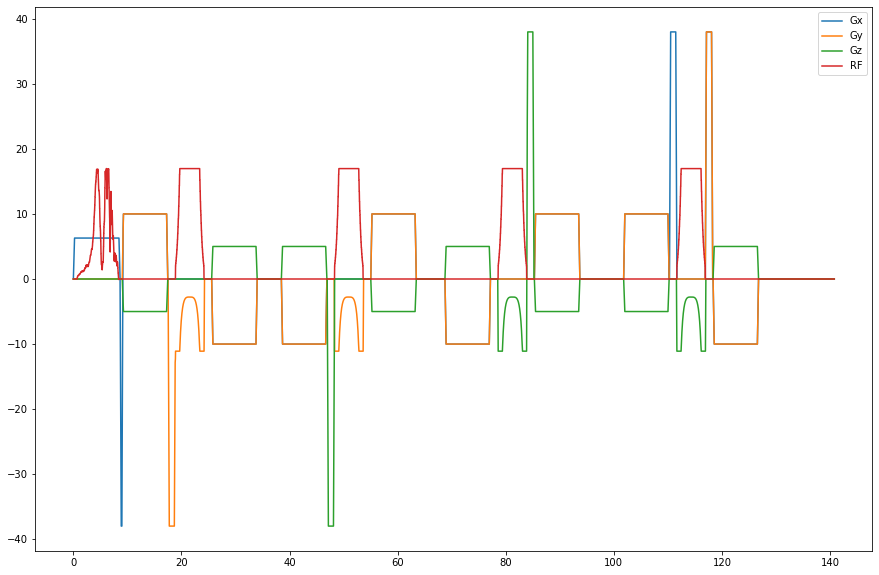

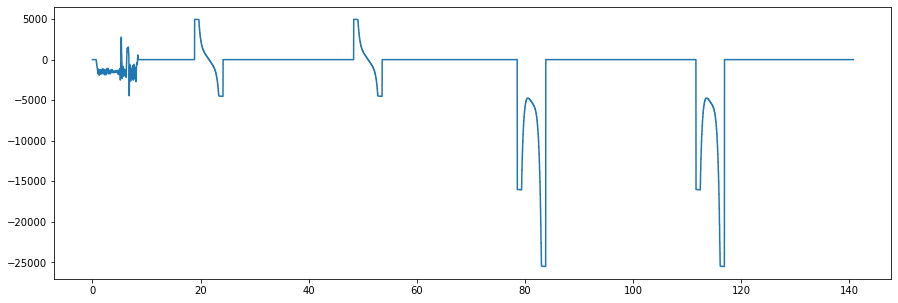

In [18]:
fig = plt.figure(figsize=(15,10))
chrono_g10_dir1.drop('RF_freq', axis=1).plot(ax=fig.gca())
plt.show()
fig = plt.figure(figsize=(15,5))
chrono_g10_dir1['RF_freq'].plot(ax=fig.gca())
plt.show()

## Find the RF regions
Identify the regions where RF is on, extract the traces in those regions, and create complex pulse descriptions.

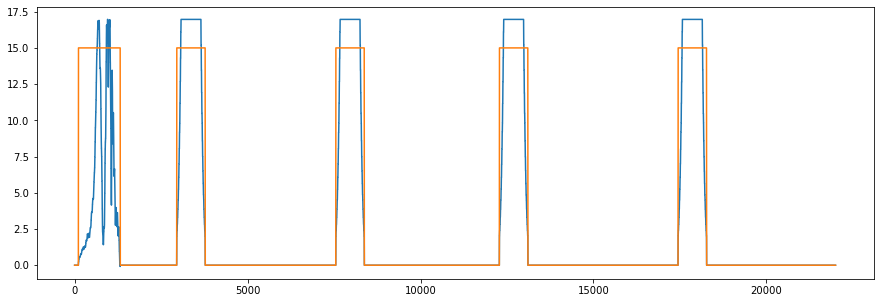

In [19]:
# Find RF regions
rf_array = chrono_g10_dir1['RF'].to_numpy()

def my_key(x):
    return x[1]==0.0
rf_indicies = [[i for i,value in it] for key,it in itertools.groupby(enumerate(rf_array), key=my_key) if key == False]

fig = plt.figure(figsize=(15,5))
plt.plot(rf_array)
index_plot = np.zeros_like(rf_array)
for rf_ind in rf_indicies:    
    index_plot[rf_ind]=15
plt.plot(index_plot)
plt.show()


In [20]:
# Extract regions of RF, frequency, and gradient modulation
rf_amps = []
rf_freqs = []
rf_grads = []
rf_amp_array = chrono_g10_dir1['RF'].to_numpy()
rf_freq_array = chrono_g10_dir1['RF_freq'].to_numpy()
gx_array = chrono_g10_dir1['Gx'].to_numpy()
gy_array = chrono_g10_dir1['Gy'].to_numpy()
gz_array = chrono_g10_dir1['Gz'].to_numpy()
rf_duration = []
tp = 6.4E-6 

for rf_ind in rf_indicies:    
    rf_amps.append(rf_amp_array[rf_ind])
    rf_freqs.append(rf_freq_array[rf_ind])
    rf_grads.append(np.stack((gx_array[rf_ind], gy_array[rf_ind], gz_array[rf_ind])).T)
    rf_duration.append(tp*len(rf_ind))

In the next cell we convert frequency modulation to phase modulation by integrating across time. We then use that to create complex pulse descriptions and we then plot the results of the five pulses. There is an excitation pulse and then two pairs of refocusing pulses. One refocusing pulse appears to have a spatial position offset.

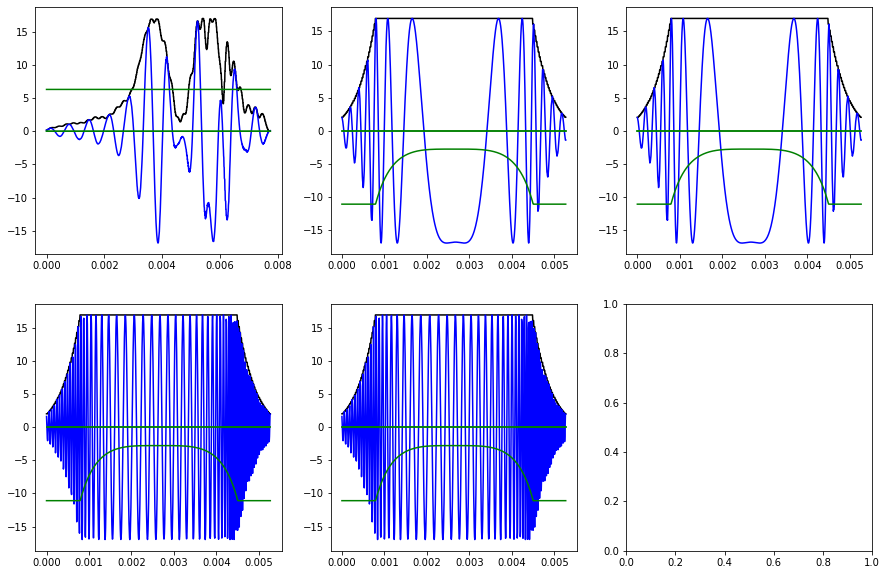

In [21]:
# Convert frequency modulation to phase modulation
rf_phases = []
for rf_f in rf_freqs:
    rf_phases.append(np.cumsum(rf_f)*2*np.pi*tp)
    
# Construct Complex pulse descriptions
rf_complex = []
for rf_a, rf_p in zip(rf_amps,rf_phases):
    rf_complex.append(rf_a * np.exp(1j*rf_p))
    
# Plot
fig, axes = plt.subplots(2,3,figsize=(15,10))
for ax, rfc, rfg, ta in zip(axes.flatten(), rf_complex, rf_grads, rf_duration):
    taxis = np.linspace(0,ta,num=rfc.size)
    ax.plot(taxis,np.abs(rfc),'k')
    ax.plot(taxis,np.real(rfc),'b')
    ax.plot(taxis,np.real(rfg),'g')

## Simulate the pulses
Pulse is simulated using a Python version of Brian Hargreaves' Bloch simulator. As ever, thank you Brian!

### Excitation pulse
Simulate the 90 over a range of offsets and positions to ensure it is working as expected.

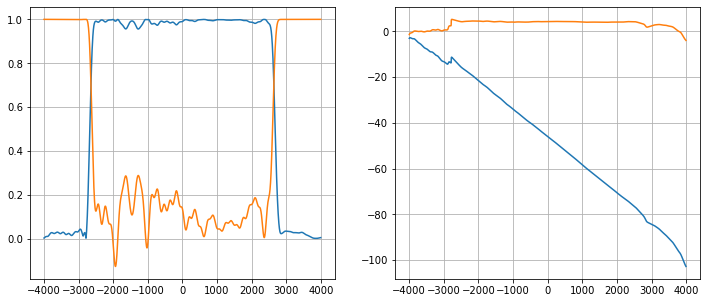

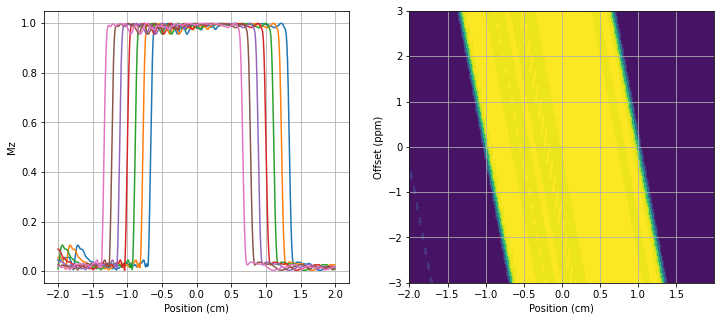

In [22]:
# Simulation of pulses
from bloch.bloch import bloch

#Excitation pulse
exc_pulse_hz = rf_complex[0] * 42.5774
exc_pulse_dur = rf_duration[0]
g = np.zeros(exc_pulse_hz.shape)

dt = exc_pulse_dur / exc_pulse_hz.size
t1 = 5.0
t2 = 5.0

dp = 0
df = np.arange(-4000,4000,5, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(exc_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(df,np.abs(mx+1j*my))
ax1.plot(df,mz)
ax1.grid()

mxy = (mx+1j*my).squeeze()
ax2.plot(df,np.unwrap(np.angle(mxy)))
centroid_time = exc_pulse_dur * 0.25
phase_factor = np.exp(1j * 2 * np.pi * df * centroid_time)
ax2.plot(df,np.unwrap(np.angle(phase_factor*(mxy))))
ax2.grid()
plt.show()

g_inhzpercm = rf_grads[0][0][0] * 42.5774 * 1000/100  # 1000 is mT->T and 100 is m->cm
g = g_inhzpercm * np.ones(exc_pulse_hz.shape)

dp = np.arange(-2,2,0.01, dtype=float)
df = np.arange(-900,901,100, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(exc_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(dp,np.abs(mx+1j*my).T[:,::3])
ax1.set_xlabel('Position (cm)')
ax1.set_ylabel('Mz')
ax1.grid()

ax2.contourf(dp,df/300,np.abs(mx+1j*my),levels=[0, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99,1.0])
ax2.set_xlabel('Position (cm)')
ax2.set_ylabel('Offset (ppm)')
ax2.grid()
plt.show()

### Refocusing pulse

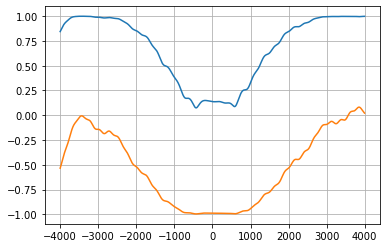

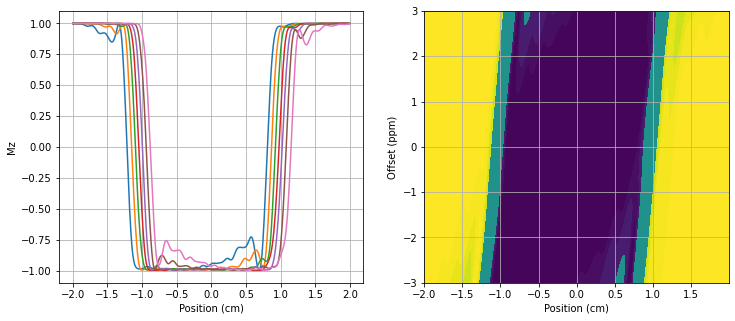

In [23]:
# Refocussing pulses
# First pulse
ref_pulse_1_hz = rf_complex[1] * 42.5774
ref_pulse_1_dur = rf_duration[1]
g = rf_grads[1][:,1] * 42.5774 * 1000/100  # 1000 is mT->T and 100 is m->cm

dt = ref_pulse_1_dur / ref_pulse_1_hz.size
t1 = 5.0
t2 = 5.0

dp = 0
df = np.arange(-4000,4000,5, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(ref_pulse_1_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)


plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.grid()
plt.show()

dp = np.arange(-2,2,0.01, dtype=float)
df = np.arange(-900,901,100, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(ref_pulse_1_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(dp,mz.T[:,::3])
ax1.set_xlabel('Position (cm)')
ax1.set_ylabel('Mz')
ax1.grid()

ax2.contourf(dp,df/300,mz,levels=[-1.0,-0.95,-0.9, -0.8, 0.8, 0.9, 0.95, 0.99,1.0])
ax2.set_xlabel('Position (cm)')
ax2.set_ylabel('Offset (ppm)')
ax2.grid()
plt.show()

### Second refocusing pulse pair (optional)
The description of the second pair of refocusing pulses appear to have an incorrect frequency/phase modulation arising from their spatial offset. This leads to significant artefacts.

These cells contain code where I explored what was going on. The actual final solution was to just use the (otherwise identical) first pair of pulses in place of the second pair.. You can skip down to the `Assemble sequence description` section.

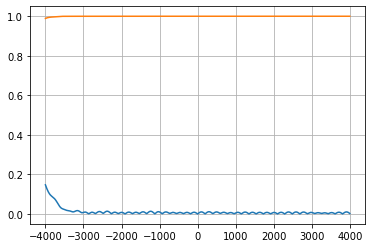

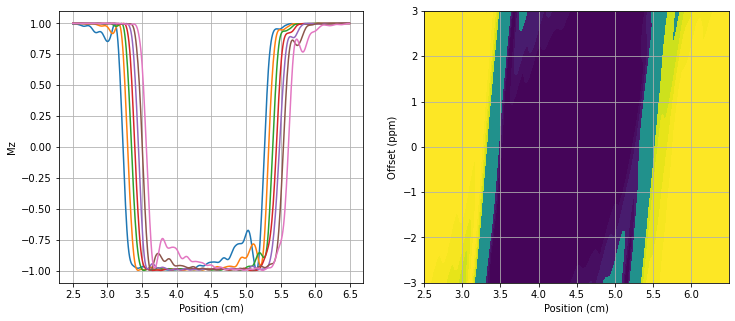

In [24]:
# Second pulse
ref_pulse_2_dur = rf_duration[3]
g = rf_grads[3][:,2] * 42.5774 * 1000/100  # 1000 is mT->T and 100 is m->cm
ref_pulse_2_hz = rf_complex[3] * 42.5774
dt = ref_pulse_2_dur / ref_pulse_2_hz.size
ref_pulse_2_hz_manual_shift = rf_complex[1] * 42.5774 * np.exp(1j * 2 * np.pi * np.cumsum(g * 4.45)*dt)
to_use = ref_pulse_2_hz_manual_shift

t1 = 5.0
t2 = 5.0
dp = 0
df = np.arange(-4000,4000,5, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(to_use, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)


plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.grid()
plt.show()

dp = np.arange(2.5,6.5,0.01, dtype=float)
df = np.arange(-900,901,100, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(to_use, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(dp,mz.T[:,::3])
ax1.set_xlabel('Position (cm)')
ax1.set_ylabel('Mz')
ax1.grid()

ax2.contourf(dp,df/300,mz,levels=[-1.0,-0.95,-0.9, -0.8, 0.8, 0.9, 0.95, 0.99,1.0])
ax2.set_xlabel('Position (cm)')
ax2.set_ylabel('Offset (ppm)')
ax2.grid()
plt.show()

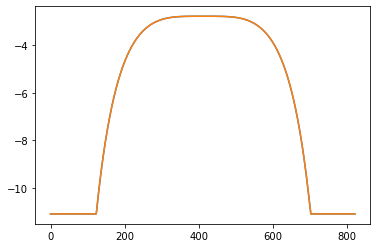

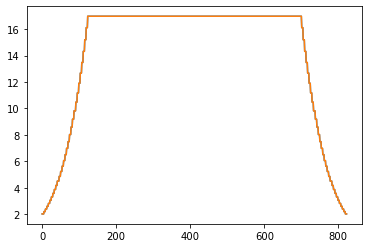

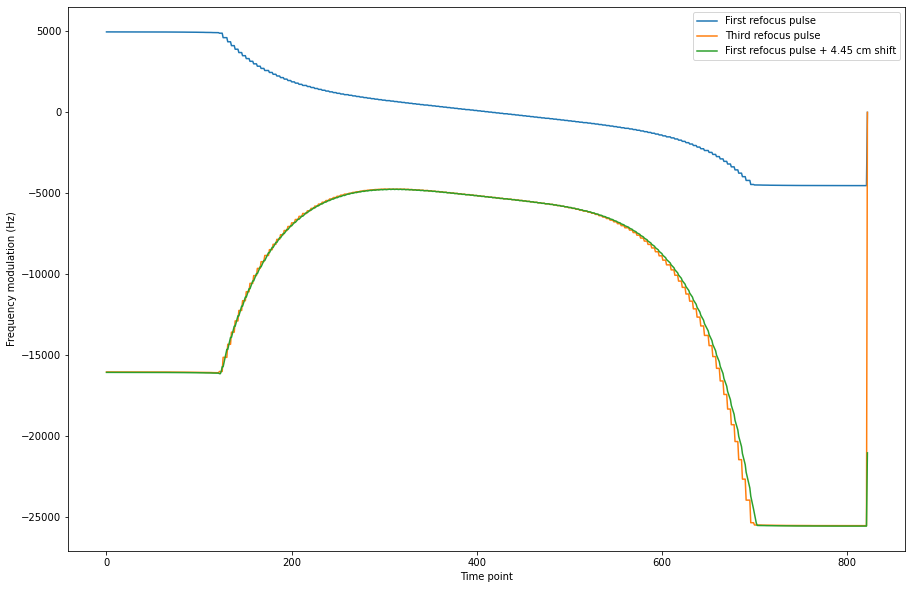

In [25]:
plt.plot(rf_grads[3][:,2])
plt.plot(rf_grads[2][:,1])
plt.show()
assert np.allclose(rf_grads[2][:,1],rf_grads[3][:,2])

plt.plot(rf_amps[3])
plt.plot(rf_amps[2])
plt.show()
assert np.allclose(rf_amps[2],rf_amps[3])

fig = plt.figure(figsize=(15,10))
plt.plot(rf_freqs[1],label='First refocus pulse')
plt.plot(rf_freqs[3],label='Third refocus pulse')
g = rf_grads[3][:,2] * 42.5774 * 1000/100  # 1000 is mT->T and 100 is m->cm
plt.plot(rf_freqs[1]+g * 4.45,label='First refocus pulse + 4.45 cm shift')
plt.xlabel('Time point')
plt.ylabel('Frequency modulation (Hz)')
plt.legend()
plt.show()

## Assemble sequence description 

We now assemble the JSON formatted sequence description as required by `fsl_mrs_sim`.

This creates a file `dw_steam.json` which will be passed to the simulator.

For a quick and dirty run change `json_dict["resolution"] = 3 * [60, ]` to `json_dict["resolution"] = 3 * [10, ]`.

In [ ]:
import json
# Pulse frequency offsets
frequency_offset = (2.0 - 4.65) * 7.00 * 42.5774

# Uniform Gradients
# 20x20x20 mm3 Voxel
ss_grad = rf_grads[0][1,0]
ss_rephase_grad = ss_grad * 0.25 * rf_duration[0]

# Claculate delays
# Delays excludes time with RF on.
d1 = 6.4E-6 * (rf_indicies[1][0]-rf_indicies[0][-1])
d2 = 6.4E-6 * (rf_indicies[2][0]-rf_indicies[1][-1])
d3 = 6.4E-6 * (rf_indicies[3][0]-rf_indicies[2][-1])
d4 = 6.4E-6 * (rf_indicies[4][0]-rf_indicies[3][-1])

p1 = rf_duration[0]*0.25 # 0.25 for the asymmetry
p2 = rf_duration[1]
p3 = rf_duration[2]
p4 = rf_duration[3]
p5 = rf_duration[4]

d5 = 0.1250176 - np.sum([p1, d1, p2, d2, p3, d3, p4, d4, p5])
delay_vec = np.array([d1, d2, d3, d4, d5])

# Generate the json dict
json_dict = {}
json_dict["sequenceName"] = "dw_sLASER"
json_dict["description"] = "7T Philips DW-sLASER sequence."
json_dict["B0"] = 7.00
json_dict["centralShift"] = 4.65

# Rx parameters
json_dict["Rx_Points"] = 2*8192
json_dict["Rx_SW"] = 6000
json_dict["Rx_LW"] = 2
json_dict["Rx_Phase"] = 0.0

# Simulation spatial extent
# Simulated for a 20x20x20mm3 voxel. Double this
json_dict["x"] = [-20, 20]
json_dict["y"] = [-20, 20]
json_dict["z"] = [-20, 20]
json_dict["resolution"] = 3 * [60, ]

# Sequence description units
json_dict["RFUnits"] = "Hz"
json_dict["GradUnits"] = "mT"
json_dict["spaceUnits"] = "mm"

# Coherence filter
json_dict["CoherenceFilter"] = [-1, 1, -1, 1, -1]

# Delays
json_dict["delays"] = delay_vec.tolist()

# Rephase areas
rp_areas = np.zeros((5, 3))
rp_areas[0, 0] = -ss_rephase_grad
json_dict["rephaseAreas"] = rp_areas.tolist()


# Assemble the RF blocks
# Each block must contain:
# "time" duration of RF.
# "frequencyOffset" offset from the centralShift in Hz
# "phaseOffset" typically 0.
# "amp" pulse amplitude modulation
# "phase" pulse phase modulation
# "grad" [x,y,z] gradient

rf_array = []
# 1. Excitation block
rf_array.append({
    "time": rf_duration[0],
    "frequencyOffset": frequency_offset,
    "phaseOffset": 0.0,
    "amp": np.abs(exc_pulse_hz).tolist(),
    "phase": np.angle(exc_pulse_hz).tolist(),
    "grad": [ss_grad, 0.0, 0.0]})
# 2. y Refocus block 1
rf_array.append({
    "time": rf_duration[1],
    "frequencyOffset": frequency_offset,
    "phaseOffset": 0.0,
    "amp": np.abs(ref_pulse_1_hz).tolist(),
    "phase": np.angle(ref_pulse_1_hz).tolist(),
    "grad": rf_grads[1].T.tolist()})
# 3. y Refocus block 2
rf_array.append({
    "time": rf_duration[1],
    "frequencyOffset": frequency_offset,
    "phaseOffset": 0.0,
    "amp": np.abs(ref_pulse_1_hz).tolist(),
    "phase": np.angle(ref_pulse_1_hz).tolist(),
    "grad": rf_grads[1].T.tolist()})
# 4. z Refocus block 1
rf_array.append({
    "time": rf_duration[1],
    "frequencyOffset": frequency_offset,
    "phaseOffset": 0.0,
    "amp": np.abs(ref_pulse_1_hz).tolist(),
    "phase": np.angle(ref_pulse_1_hz).tolist(),
    "grad": rf_grads[3].T.tolist()})
# 5. z Refocus block 2
rf_array.append({
    "time": rf_duration[1],
    "frequencyOffset": frequency_offset,
    "phaseOffset": 0.0,
    "amp": np.abs(ref_pulse_1_hz).tolist(),
    "phase": np.angle(ref_pulse_1_hz).tolist(),
    "grad": rf_grads[3].T.tolist()})

# Generate OFF
json_dict["RF"] = rf_array

# Write the json
file_name = f'dw_slaser.json'
with open(file_name, 'w') as fp:
    json.dump(json_dict, fp, indent=1)


### Create a custom set of spin systems to test the sequence.
Each system is a single spin at an integer ppm value. Quick and it will enable us to see that we get uniform, in-phase signal across a range of ppm values.

In [29]:
%%writefile test_spinsys.json
{
"sys1": {
    "j": [[0]],
    "shifts":[1.0],
    "name": "1",
    "scaleFactor": 1.0
},
"sys15": {
    "j": [[0]],
    "shifts":[1.5],
    "name": "1_5",
    "scaleFactor": 1.0
},
"sys2": {
    "j": [[0]],
    "shifts":[2.0],
    "name": "2",
    "scaleFactor": 1.0
},
"sys25": {
    "j": [[0]],
    "shifts":[2.5],
    "name": "2_5",
    "scaleFactor": 1.0
},
"sys3": {
    "j": [[0]],
    "shifts":[3.0],
    "name": "3",
    "scaleFactor": 1.0
},
"sys35": {
    "j": [[0]],
    "shifts":[3.5],
    "name": "3_5",
    "scaleFactor": 1.0
},
"sys4": {
    "j": [[0]],
    "shifts":[4.0],
    "name": "4",
    "scaleFactor": 1.0
}
}

Writing test_spinsys.json


Run the test

In [30]:
%sx fsl_mrs_sim -s test_spinsys.json -o slaser_test -p -2.0 dw_steam.json --overwrite 

['Simulation running using mode 1d. Axis order = [0 1 2].',
 'Auto-phase adjustment. Phasing peak position = 2.65 ppm',
 'Rx_Phase: 0.0',
 'Additional phase: -2.426',
 'Final Rx_Phase: -2.426',
 'Running simulation on sys1.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys3.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys35.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys15.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys4.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys25.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys2.',
 'Simulation running using mode 1d. Axis order = [0 1 2].']

View the test results

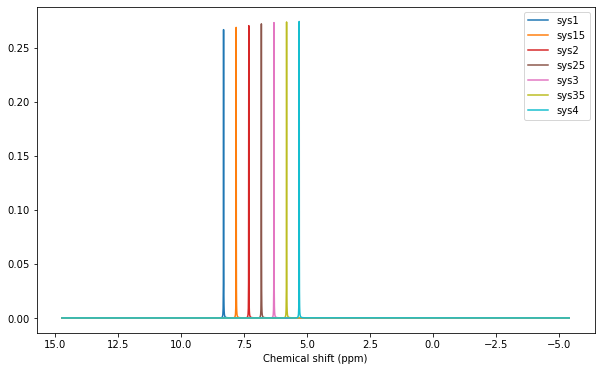

In [31]:
from fsl_mrs.utils import mrs_io
basis = mrs_io.read_basis('slaser_test/')
fig = plt.figure(figsize=(10,6))
basis.plot()
# plt.xlim([5.0,0.2])
plt.show()

## Now run the actual simulation
The simulation will use the metabolites listed in `metabs.txt`.

In [426]:
%sx fsl_mrs_sim -b metabs.txt -o dwslaser_basis -p -2.0 dw_slaser.json --overwrite 

["Identified spinsystems: ['Ala', 'Asc', 'Asp', 'GPC', 'PCh', 'Cr', 'PCr', 'GABA', 'Glc', 'Gln', 'Glu', 'GSH', 'Ins', 'Lac', 'NAA', 'NAAG', 'PE', 'Scyllo', 'Tau']",
 'Simulation running using mode 1d. Axis order = [0 1 1 2 2].',
 'Auto-phase adjustment. Phasing peak position = 2.65 ppm',
 'Rx_Phase: 0.0',
 'Additional phase: -0.870',
 'Final Rx_Phase: -0.870',
 'Running simulation on PCr.',
 'Simulation running using mode 1d. Axis order = [0 1 1 2 2].',
 'Simulation running using mode 1d. Axis order = [0 1 1 2 2].',
 'Running simulation on GSH.',
 'Simulation running using mode 1d. Axis order = [0 1 1 2 2].',
 'Simulation running using mode 1d. Axis order = [0 1 1 2 2].',
 'Simulation running using mode 1d. Axis order = [0 1 1 2 2].',
 'Running simulation on NAAG.',
 'Simulation running using mode 1d. Axis order = [0 1 1 2 2].',
 'Simulation running using mode 1d. Axis order = [0 1 1 2 2].',
 'Simulation running using mode 1d. Axis order = [0 1 1 2 2].',
 'Running simulation on Cr.',
 

### View the results
To simplify the code in the practical notebooks we conjugate the basis set here to get the correct phase/frequency convention.

A copy is saved back out.

In [27]:
from fsl_mrs.utils import mrs_io
from fsl_mrs.utils import basis_tools as btools

basis = mrs_io.read_basis('dwslaser_basis/')
mod_basis = btools.conjugate_basis(basis)

mod_basis.save('dwslaser_basis_conj')

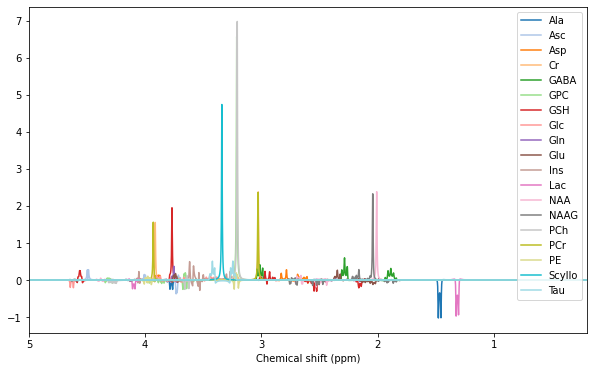

In [28]:
fig = plt.figure(figsize=(10,6))
mod_basis.plot()
plt.xlim([5.0,0.2])
plt.show()